In [10]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
MMS Message Extractor - LangGraph Implementation (Refactored for Modular Nodes)
"""

import os
import re
import json
import pandas as pd
import numpy as np
from typing import List, Dict, Any, TypedDict, Optional
from langgraph.graph import Graph, StateGraph
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_anthropic import ChatAnthropic
from sentence_transformers import SentenceTransformer
import torch
from kiwipiepy import Kiwi

# Set pandas display options
pd.set_option('display.max_colwidth', 500)

# Environment variables setup
API_KEYS = {
    'ANTHROPIC_API_KEY': os.getenv("ANTHROPIC_API_KEY"),
}
for key, value in API_KEYS.items():
    os.environ[key] = value

# Initialize models
model = SentenceTransformer('jhgan/ko-sbert-nli')
kiwi = Kiwi()
kiwi_raw = Kiwi()
kiwi_raw.space_tolerance = 2

# Define state types
class ExtractionState(TypedDict):
    message_id: str
    message: str
    tokens: List[str]
    entities: List[Dict[str, Any]]
    search_results: Dict[str, Any]
    final_result: Optional[Dict[str, Any]]
    error: Optional[str]

# Output schema
class ExtractionResult(BaseModel):
    title: str = Field(description="광고 제목. 광고의 핵심 주제와 가치 제안을 명확하게 설명할 수 있도록 생성")
    purpose: List[str] = Field(description="광고의 주요 목적을 다음 중에서 선택(복수 가능): [상품 가입 유도, 대리점 방문 유도, 웹/앱 접속 유도, 이벤트 응모 유도, 혜택 안내, 쿠폰 제공 안내, 경품 제공 안내, 기타 정보 제공]")
    product: List[Dict[str, Any]] = Field(description="추출된 상품 정보")
    channel: List[Dict[str, Any]] = Field(description="채널 정보")
    pgm: List[Dict[str, Any]] = Field(description="PGM 정보")

# --- Task Agent: Tokenizer ---
def tokenizer_agent(state: ExtractionState) -> ExtractionState:
    print("[Tokenizer Agent] Input message:", state['message'][:100], "..." if len(state['message']) > 100 else "")
    try:
        result_msg = kiwi.tokenize(state['message'], normalize_coda=True, z_coda=False, split_complex=False)
        tokens = [token.form for token in result_msg]
        state['tokens'] = tokens
        print(f"[Tokenizer Agent] Output tokens: {tokens[:10]}{'...' if len(tokens) > 10 else ''}")
        return state
    except Exception as e:
        state['error'] = f"Tokenizer error: {str(e)}"
        print(f"[Tokenizer Agent] Error: {state['error']}")
        return state

# --- Task Agent: Entity Matcher ---
def entity_matcher_agent(state: ExtractionState) -> ExtractionState:
    print(f"[Entity Matcher Agent] Input tokens: {state['tokens'][:10]}{'...' if len(state['tokens']) > 10 else ''}")
    try:
        result_msg = kiwi.tokenize(state['message'], normalize_coda=True, z_coda=False, split_complex=False)
        entities = []
        for token in result_msg:
            if token.tag == 'NNP' and len(token.form) >= 2:
                entities.append({
                    'text': token.form,
                    'start': token.start,
                    'end': token.end,
                    'tag': token.tag
                })
        state['entities'] = entities
        print(f"[Entity Matcher Agent] Output entities: {entities}")
        return state
    except Exception as e:
        state['error'] = f"Entity matcher error: {str(e)}"
        print(f"[Entity Matcher Agent] Error: {state['error']}")
        return state

# --- Task Agent: Product Search ---
def product_search_agent(state: ExtractionState) -> ExtractionState:
    print(f"[Product Search Agent] Input entities: {state['entities']}")
    try:
        item_pdf = pd.read_csv("./data/item_info_all_250527.csv", usecols=["item_nm", "item_id", "item_desc", "domain"])
        products = []
        for entity in state['entities']:
            matches = item_pdf[item_pdf['item_nm'].str.contains(entity['text'], case=False, na=False)]
            if not matches.empty:
                for _, match in matches.iterrows():
                    products.append({
                        'item_name_in_message': entity['text'],
                        'item_name_in_voca': match['item_nm'],
                        'item_id': match['item_id'],
                        'domain': match['domain'],
                        'item_desc': match['item_desc'],
                        'action': '고객에게 기대하는 행동. [구매, 가입, 사용, 방문, 참여, 코드입력, 쿠폰다운로드, 없음, 기타] 중에서 선택'
                    })
        state['products'] = products
        print(f"[Product Search Agent] Products found: {products}")
        return state
    except Exception as e:
        state['error'] = f"Product search error: {str(e)}"
        print(f"[Product Search Agent] Error: {state['error']}")
        return state

# --- Task Agent: PGM Search ---
def pgm_search_agent(state: ExtractionState) -> ExtractionState:
    print(f"[PGM Search Agent] Input message: {state['message'][:100]}{'...' if len(state['message']) > 100 else ''}")
    try:
        pgm_pdf = pd.read_csv("./data/pgm_tag_ext_250516.csv", usecols=["pgm_id", "pgm_nm", "clue_tag"])
        def preprocess_text(text):
            text = re.sub(r'[^\w\s]', ' ', text)
            text = re.sub(r'\s+', ' ', text)
            return text.strip()
        clue_embeddings = model.encode(
            pgm_pdf[["pgm_nm","clue_tag"]].apply(
                lambda x: preprocess_text(x['pgm_nm'].lower())+" "+x['clue_tag'].lower(), 
                axis=1
            ).tolist(), 
            convert_to_tensor=True
        )
        mms_embedding = model.encode([state['message'].lower()], convert_to_tensor=True)
        similarities = torch.nn.functional.cosine_similarity(
            mms_embedding,  
            clue_embeddings,  
            dim=1 
        ).cpu().numpy()
        pgm_pdf['sim'] = similarities
        pgm_pdf = pgm_pdf.sort_values('sim', ascending=False)
        pgm_candidates = pgm_pdf[['pgm_id','pgm_nm','clue_tag','sim']].head(5).to_dict('records')
        state['pgm_candidates'] = pgm_candidates
        print(f"[PGM Search Agent] PGM candidates: {pgm_candidates}")
        return state
    except Exception as e:
        state['error'] = f"PGM search error: {str(e)}"
        print(f"[PGM Search Agent] Error: {state['error']}")
        return state

# --- Task Agent: Message DB Search ---
def message_db_agent(state: ExtractionState) -> ExtractionState:
    print(f"[Message DB Agent] Input message_id: {state['message_id']}")
    try:
        mms_pdf = pd.read_csv("./data/mms_data_250408.csv", usecols=["msg_nm", "mms_phrs", "msg", "offer_dt"])
        message_row = mms_pdf[(mms_pdf['msg_nm'] == state['message_id']) | (mms_pdf['msg'] == state['message'])]
        message_info = message_row.iloc[0].to_dict() if not message_row.empty else {"msg": state['message']}
        state['message_info'] = message_info
        print(f"[Message DB Agent] Message info: {message_info}")
        return state
    except Exception as e:
        state['error'] = f"Message DB error: {str(e)}"
        print(f"[Message DB Agent] Error: {state['error']}")
        return state

# --- Master Agent (Hub) ---
def master_agent(state: ExtractionState) -> ExtractionState:
    print("[Master Agent] Orchestrating task agents...")
    # Call each task agent in sequence (could be parallelized)
    state = tokenizer_agent(state)
    state = entity_matcher_agent(state)
    state = product_search_agent(state)
    state = pgm_search_agent(state)
    state = message_db_agent(state)
    # Aggregate results into search_results for LLM
    state['search_results'] = {
        'message_info': state.get('message_info', {"msg": state['message']}),
        'products': state.get('products', []),
        'pgm_candidates': state.get('pgm_candidates', [])
    }
    print(f"[Master Agent] Aggregated search_results: {json.dumps(state['search_results'], ensure_ascii=False)[:300]}...")
    return state

# --- Node: LLM (Final Synthesis) ---
def llm_node(state: ExtractionState) -> ExtractionState:
    print(f"[LLM Node] Input search_results: {json.dumps(state['search_results'], ensure_ascii=False)[:300]}...")
    try:
        llm = ChatAnthropic(
            model="claude-3-7-sonnet-20250219",
            max_tokens=3000
        )
        prompt = ChatPromptTemplate.from_messages([
            ("system", """당신은 SKT 캠페인 메시지에서 정확한 정보를 추출하는 전문가입니다. \n아래 schema에 따라 광고 메시지를 분석하여 완전하고 정확한 JSON 객체를 생성해 주세요."""),
            ("human", """### 분석 대상 광고 메세지 ###\n{message}\n\n### 메시지 DB 정보 ###\n{message_info}\n\n### 추출된 상품 정보 (오퍼 마스터) ###\n{products}\n\n### PGM 후보 ###\n{pgm_candidates}\n\n### 결과 Schema ###\n{schema}\n\n응답은 설명 없이 순수한 JSON 형식으로만 제공하세요.""")
        ])
        message_info = state['search_results'].get('message_info', {"msg": state['message']})
        chain = prompt | llm | JsonOutputParser()
        result = chain.invoke({
            "message": state['message'],
            "message_info": json.dumps(message_info, ensure_ascii=False),
            "products": json.dumps(state['search_results']['products'], ensure_ascii=False),
            "pgm_candidates": json.dumps(state['search_results']['pgm_candidates'], ensure_ascii=False),
            "schema": ExtractionResult.schema_json()
        })
        print(f"[LLM Node] Output result: {json.dumps(result, ensure_ascii=False)[:300]}...")
        state['final_result'] = result
        return state
    except Exception as e:
        state['error'] = f"LLM error: {str(e)}"
        print(f"[LLM Node] Error: {state['error']}")
        return state

# --- Graph Construction ---
def create_extraction_graph() -> Graph:
    workflow = StateGraph(ExtractionState)
    workflow.add_node("master_agent", master_agent)
    workflow.add_node("llm", llm_node)
    workflow.add_edge("master_agent", "llm")
    workflow.set_entry_point("master_agent")
    workflow.set_finish_point("llm")
    return workflow.compile()


In [11]:
msg_text_list = ["""광고 제목:[SK텔레콤] 2월 0 day 혜택 안내광고 내용:(광고)[SKT] 2월 0 day 혜택 안내__[2월 10일(토) 혜택]_만 13~34세 고객이라면_베어유 모든 강의 14일 무료 수강 쿠폰 드립니다!_(선착순 3만 명 증정)_▶ 자세히 보기: http://t-mms.kr/t.do?m=#61&s=24589&a=&u=https://bit.ly/3SfBjjc__■ 에이닷 X T 멤버십 시크릿코드 이벤트_에이닷 T 멤버십 쿠폰함에 '에이닷이빵쏜닷'을 입력해보세요!_뚜레쥬르 데일리우유식빵 무료 쿠폰을 드립니다._▶ 시크릿코드 입력하러 가기: https://bit.ly/3HCUhLM__■ 문의: SKT 고객센터(1558, 무료)_무료 수신거부 1504""","""광고 제목:통화 부가서비스를 패키지로 저렴하게!광고 내용:(광고)[SKT] 콜링플러스 이용 안내  #04 고객님, 안녕하세요. <콜링플러스>에 가입하고 콜키퍼, 컬러링, 통화가능통보플러스까지 총 3가지의 부가서비스를 패키지로 저렴하게 이용해보세요.  ■ 콜링플러스 - 이용요금: 월 1,650원, 부가세 포함 - 콜키퍼(550원), 컬러링(990원), 통화가능통보플러스(770원)를 저렴하게 이용할 수 있는 상품  ■ 콜링플러스 가입 방법 - T월드 앱: 오른쪽 위에 있는 돋보기를 눌러 콜링플러스 검색 > 가입  ▶ 콜링플러스 가입하기: http://t-mms.kr/t.do?m=#61&u=https://skt.sh/17tNH  ■ 유의 사항 - 콜링플러스에 가입하면 기존에 이용 중인 콜키퍼, 컬러링, 통화가능통보플러스 서비스는 자동으로 해지됩니다. - 기존에 구매한 컬러링 음원은 콜링플러스 가입 후에도 계속 이용할 수 있습니다.(시간대, 발신자별 설정 정보는 다시 설정해야 합니다.)  * 최근 다운로드한 음원은 보관함에서 무료로 재설정 가능(다운로드한 날로부터 1년 이내)   ■ 문의: SKT 고객센터(114)  SKT와 함께해주셔서 감사합니다.  무료 수신거부 1504\n    ', ""","""(광고)[SKT] 1월 0 day 혜택 안내_ _[1월 20일(토) 혜택]_만 13~34세 고객이라면 _CU에서 핫바 1,000원에 구매 하세요!_(선착순 1만 명 증정)_▶ 자세히 보기 : http://t-mms.kr/t.do?m=#61&s=24264&a=&u=https://bit.ly/3H2OHSs__■ 에이닷 X T 멤버십 구독캘린더 이벤트_0 day 일정을 에이닷 캘린더에 등록하고 혜택 날짜에 알림을 받아보세요! _알림 설정하면 추첨을 통해 [스타벅스 카페 라떼tall 모바일쿠폰]을 드립니다. _▶ 이벤트 참여하기 : https://bit.ly/3RVSojv_ _■ 문의: SKT 고객센터(1558, 무료)_무료 수신거부 1504""","""'[T 우주] 넷플릭스와 웨이브를 월 9,900원에! \n(광고)[SKT] 넷플릭스+웨이브 월 9,900원, 이게 되네! __#04 고객님,_넷플릭스와 웨이브 둘 다 보고 싶었지만, 가격 때문에 망설이셨다면 지금이 바로 기회! __오직 T 우주에서만, _2개월 동안 월 9,900원에 넷플릭스와 웨이브를 모두 즐기실 수 있습니다.__8월 31일까지만 드리는 혜택이니, 지금 바로 가입해 보세요! __■ 우주패스 Netflix 런칭 프로모션 _- 기간 : 2024년 8월 31일(토)까지_- 혜택 : 우주패스 Netflix(광고형 스탠다드)를 2개월 동안 월 9,900원에 이용 가능한 쿠폰 제공_▶ 프로모션 자세히 보기: http://t-mms.kr/jAs/#74__■ 우주패스 Netflix(월 12,000원)  _- 기본 혜택 : Netflix 광고형 스탠다드 멤버십_- 추가 혜택 : Wavve 콘텐츠 팩 _* 추가 요금을 내시면 Netflix 스탠다드와 프리미엄 멤버십 상품으로 가입 가능합니다.  __■ 유의 사항_-  프로모션 쿠폰은 1인당 1회 다운로드 가능합니다. _-  쿠폰 할인 기간이 끝나면 정상 이용금액으로 자동 결제 됩니다. __■ 문의: T 우주 고객센터 (1505, 무료)__나만의 구독 유니버스, T 우주 __무료 수신거부 1504'""","""광고 제목:[SK텔레콤] T건강습관 X AIA Vitality, 우리 가족의 든든한 보험!광고 내용:(광고)[SKT] 가족의 든든한 보험 (무배당)AIA Vitality 베스트핏 보장보험 안내  고객님, 안녕하세요. 4인 가족 표준생계비, 준비하고 계시나요? (무배당)AIA Vitality 베스트핏 보장보험(디지털 전용)으로 최대 20% 보험료 할인과 가족의 든든한 보험 보장까지 누려 보세요.   ▶ 자세히 보기: http://t-mms.kr/t.do?m=#61&u=https://bit.ly/36oWjgX  ■ AIA Vitality  혜택 - 매달 리워드 최대 12,000원 - 등급 업그레이드 시 특별 리워드 - T건강습관 제휴 할인 최대 40% ※ 제휴사별 할인 조건과 주간 미션 달성 혜택 등 자세한 내용은 AIA Vitality 사이트에서 확인하세요. ※ 이 광고는 AIA생명의 광고이며 SK텔레콤은 모집 행위를 하지 않습니다.  - 보험료 납입 기간 중 피보험자가 장해분류표 중 동일한 재해 또는 재해 이외의 동일한 원인으로 여러 신체 부위의 장해지급률을 더하여 50% 이상인 장해 상태가 된 경우 차회 이후의 보험료 납입 면제 - 사망보험금은 계약일(부활일/효력회복일)로부터 2년 안에 자살한 경우 보장하지 않음 - 일부 특약 갱신 시 보험료 인상 가능 - 기존 계약 해지 후 신계약 체결 시 보험인수 거절, 보험료 인상, 보장 내용 변경 가능 - 해약 환급금(또는 만기 시 보험금이나 사고보험금)에 기타 지급금을 합해 5천만 원까지(본 보험 회사 모든 상품 합산) 예금자 보호 - 계약 체결 전 상품 설명서 및 약관 참조 - 월 보험료 5,500원(부가세 포함)  * 생명보험협회 심의필 제2020-03026호(2020-09-22) COM-2020-09-32426  ■문의: 청약 관련(1600-0880)  무료 수신거부 1504    """]message_idx = 1graph = create_extraction_graph()# User can provide either a message string or a msg_nmuser_message = msg_text_list[message_idx]  # <-- Set this to your message string to use direct inputmessage_id = None    # <-- Or set this to a valid msg_nm to use DB lookupif user_message is not None and user_message.strip():    message = user_message.strip()    message_id = Noneelse:    if not message_id:        message_id = "<PUT_A_VALID_MSG_NM_HERE>"  # fallback example    mms_pdf = pd.read_csv("./data/mms_data_250408.csv", usecols=["msg_nm", "mms_phrs", "msg", "offer_dt"])    message_row = mms_pdf.query(f"msg_nm == '{message_id}'")    if message_row.empty:        print(f"Error: Message msg_nm {message_id} not found.")    message = message_row['msg'].iloc[0]print("[Main] Initial message_id:", message_id)print("[Main] Initial message (first 100 chars):", message[:100], "..." if len(message) > 100 else "")initial_state = {    "message_id": message_id if message_id else "",    "message": message,    "tokens": [],    "entities": [],    "search_results": {},    "final_result": None,    "error": None}try:    result = graph.invoke(initial_state)    if result['error']:        print(f"[Main] Error: {result['error']}")    else:        print("\n[Main] Extraction Result:")        print(json.dumps(result['final_result'], indent=2, ensure_ascii=False))except Exception as e:    print(f"[Main] Error during extraction: {str(e)}")

[Main] Initial message_id: None
[Main] Initial message (first 100 chars): 광고 제목:통화 부가서비스를 패키지로 저렴하게!
광고 내용:(광고)[SKT] 콜링플러스 이용 안내  #04 고객님, 안녕하세요. <콜링플러스>에 가입하고 콜키퍼, 컬러링, 통화가능 ...
[Master Agent] Orchestrating task agents...
[Tokenizer Agent] Input message: 광고 제목:통화 부가서비스를 패키지로 저렴하게!
광고 내용:(광고)[SKT] 콜링플러스 이용 안내  #04 고객님, 안녕하세요. <콜링플러스>에 가입하고 콜키퍼, 컬러링, 통화가능 ...
[Tokenizer Agent] Output tokens: ['광고', '제목', ':', '통화', '부', '가', '서비스', '를', '패키지', '로']...
[Entity Matcher Agent] Input tokens: ['광고', '제목', ':', '통화', '부', '가', '서비스', '를', '패키지', '로']...
[Entity Matcher Agent] Output entities: [{'text': '콜링', 'start': 43, 'end': 45, 'tag': 'NNP'}, {'text': '콜링', 'start': 73, 'end': 75, 'tag': 'NNP'}, {'text': '콜링', 'start': 143, 'end': 145, 'tag': 'NNP'}, {'text': '콜키퍼', 'start': 176, 'end': 179, 'tag': 'NNP'}, {'text': '콜링', 'start': 235, 'end': 237, 'tag': 'NNP'}, {'text': '콜링', 'start': 274, 'end': 276, 'tag': 'NNP'}, {'text': '콜링', 'start': 291, 'end': 293, 'tag': 'NNP'}, {'text': '콜링', 's

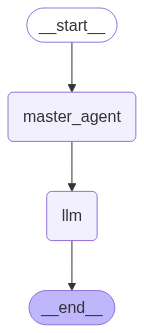

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass